In [79]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np
#import scipy as sc
import custom_function as cf


import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Cluster and seasonal analysis (daytime patterns)

In [80]:
 
df = pd.read_csv("/Users/nkochura@us.ibm.com/Documents/ML_COMPETITION_DATAAI/https-github.ibm.com-ML4DevOps/data/grafana_data_cpu.csv")

df.head()

,timestamp,value,http
0,4/21/19 0:00,18.5,"9,244"
1,4/21/19 0:15,15.2,"9,304"
2,4/21/19 0:30,16.2,"9,364"
3,4/21/19 0:45,19.2,"9,424"
4,4/21/19 1:00,19.4,"9,484"


In [81]:
print(df.info())

print(df['value'].mean())
print(df['timestamp'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 3 columns):
timestamp    673 non-null object
value        673 non-null float64
http         673 non-null object
dtypes: float64(1), object(2)
memory usage: 15.9+ KB
None
17.188261515601784
0    4/21/19 0:00
1    4/21/19 0:15
2    4/21/19 0:30
3    4/21/19 0:45
4    4/21/19 1:00
5    4/21/19 1:15
6    4/21/19 1:30
7    4/21/19 1:45
8    4/21/19 2:00
9    4/21/19 2:15
Name: timestamp, dtype: object


0   2019-04-21 00:00:00
1   2019-04-21 00:15:00
2   2019-04-21 00:30:00
3   2019-04-21 00:45:00
4   2019-04-21 01:00:00
5   2019-04-21 01:15:00
6   2019-04-21 01:30:00
7   2019-04-21 01:45:00
8   2019-04-21 02:00:00
9   2019-04-21 02:15:00
Name: timestamp, dtype: datetime64[ns]


<IPython.core.display.Javascript object>


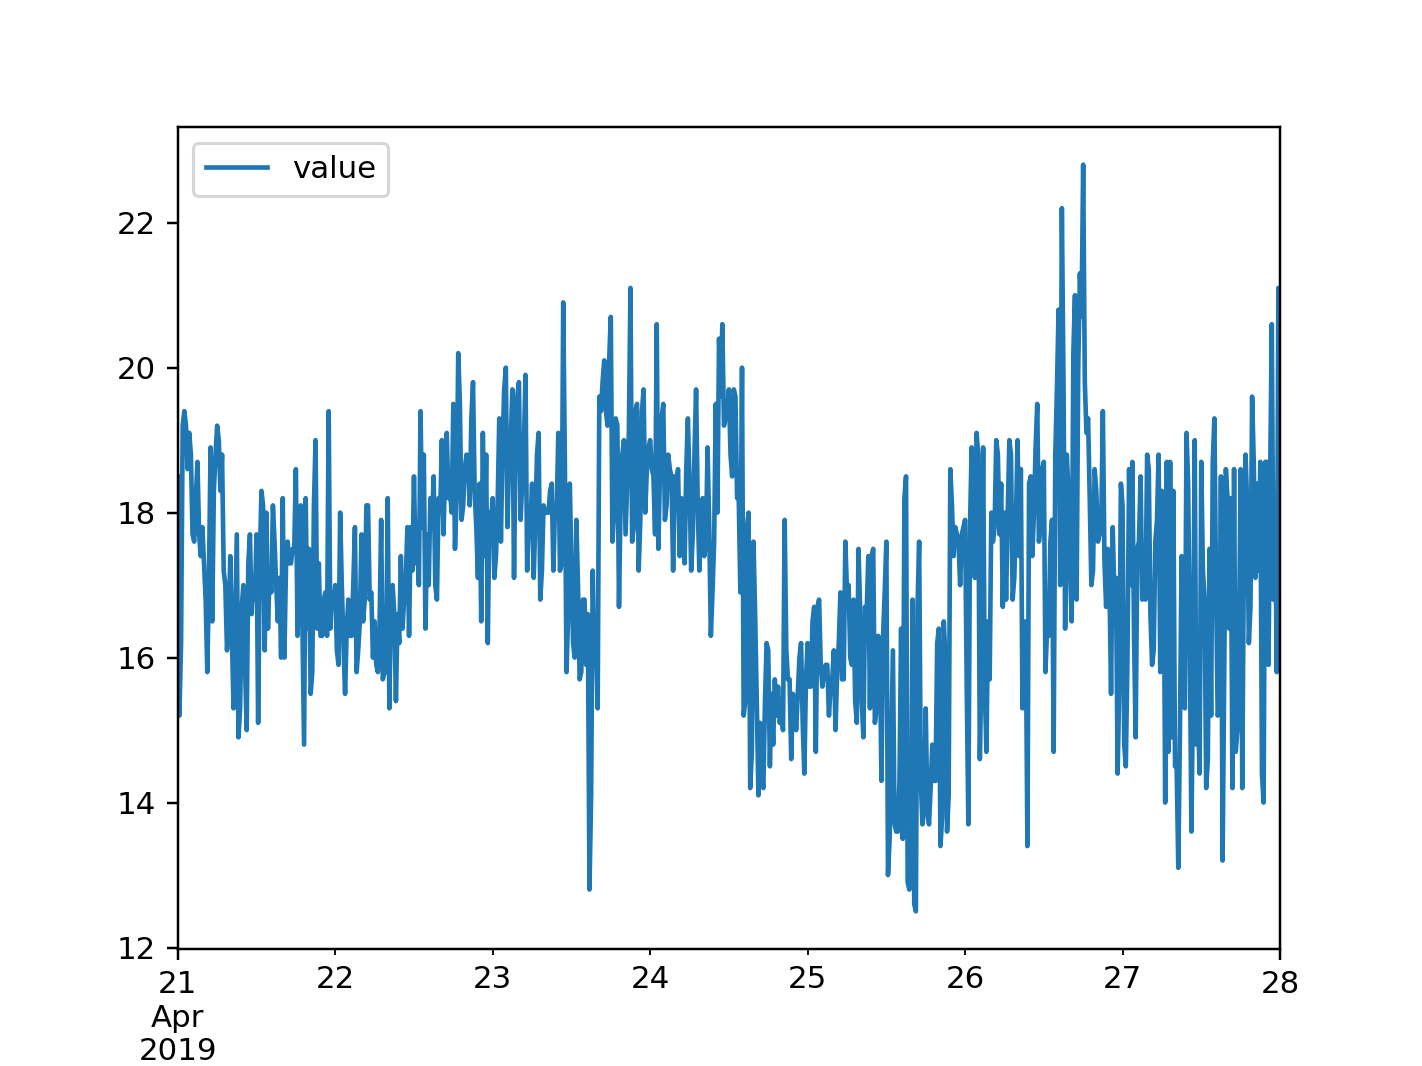

In [82]:
 # change the type of time  column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'].head(10))

# plot the data
df.plot(x='timestamp', y='value')

Extracting some useful features

<IPython.core.display.Javascript object>


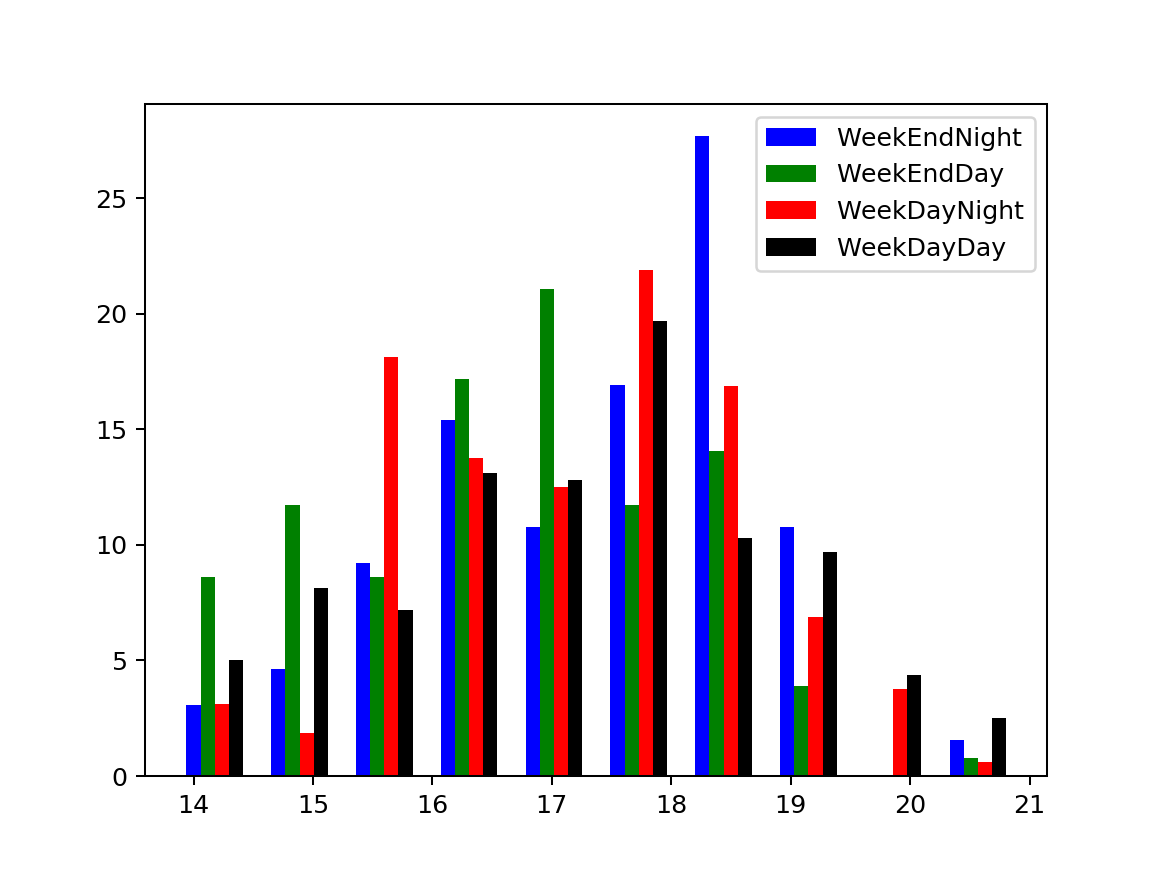

In [84]:

df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset
outliers_fraction = 0.01
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndDay')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayDay')

plt.legend()
plt.show()


# Cluster models and anomaly  

We group together the combination of features. The points that are far from the cluster are points we  consider those points as anomalies.

In [86]:

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

<IPython.core.display.Javascript object>


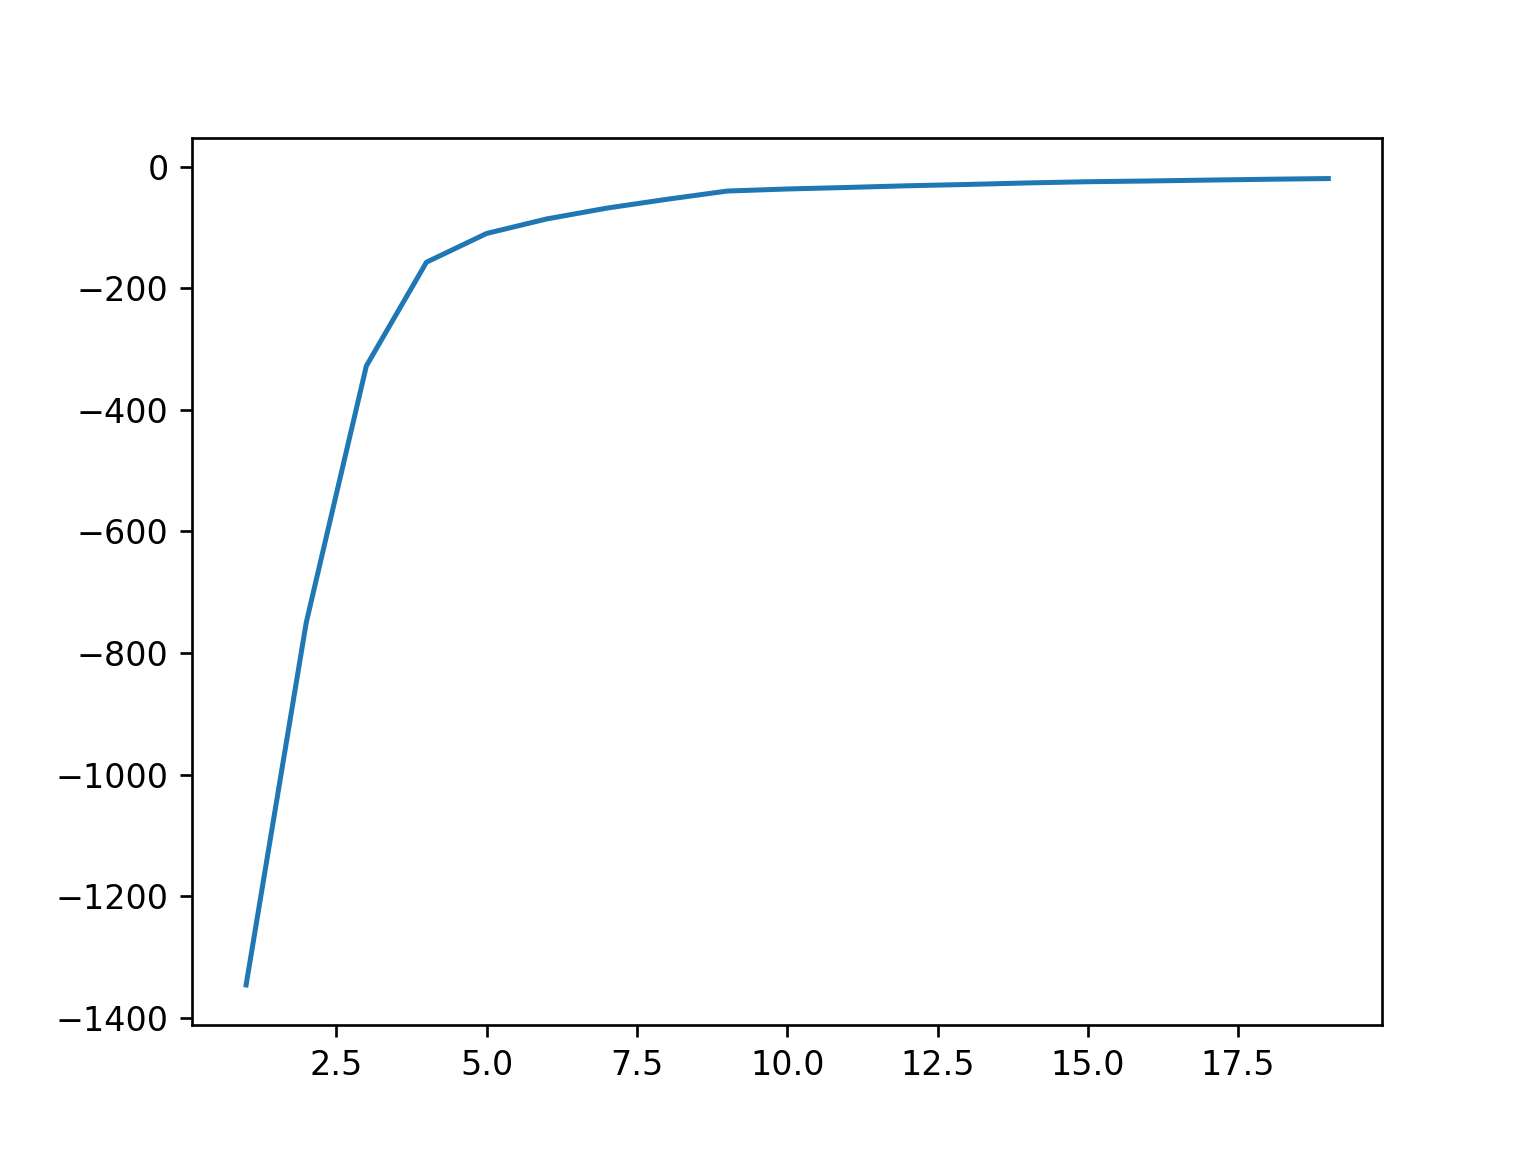

In [62]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [92]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = cf.getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

<IPython.core.display.Javascript object>


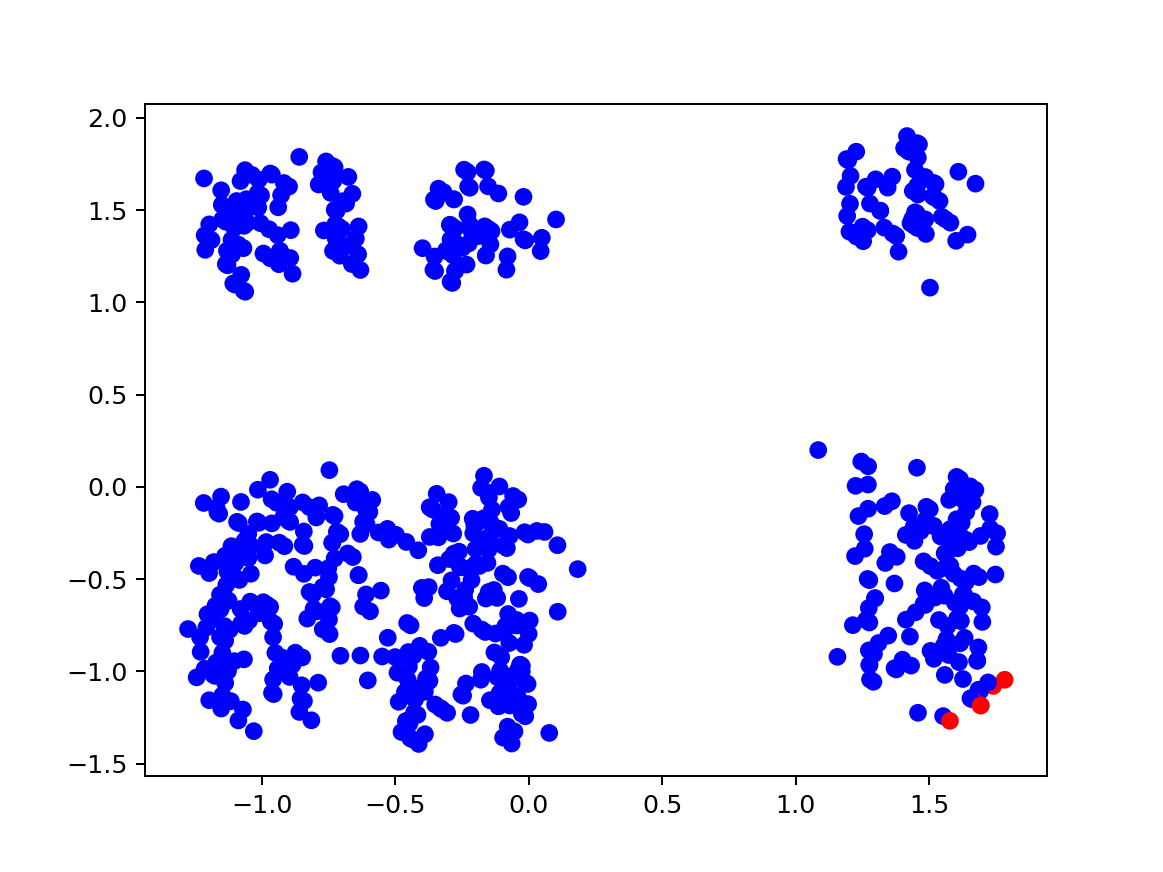

In [93]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.show()

<IPython.core.display.Javascript object>


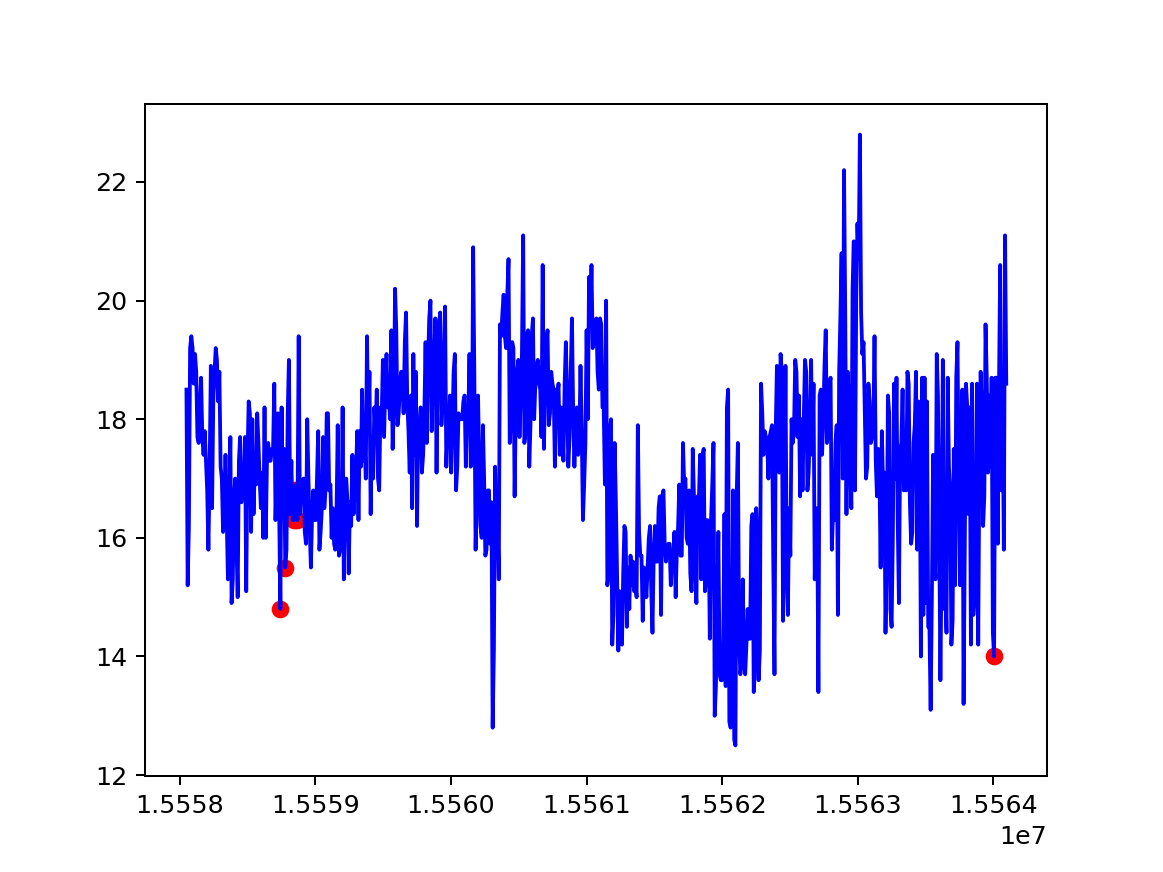

In [94]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly1'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

# Isolation forest

In [95]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly2'] = pd.Series(model.predict(data))
df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )
print(df['anomaly2'].value_counts())

0    666
1      7
Name: anomaly2, dtype: int64


/Users/nkochura@us.ibm.com/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<IPython.core.display.Javascript object>


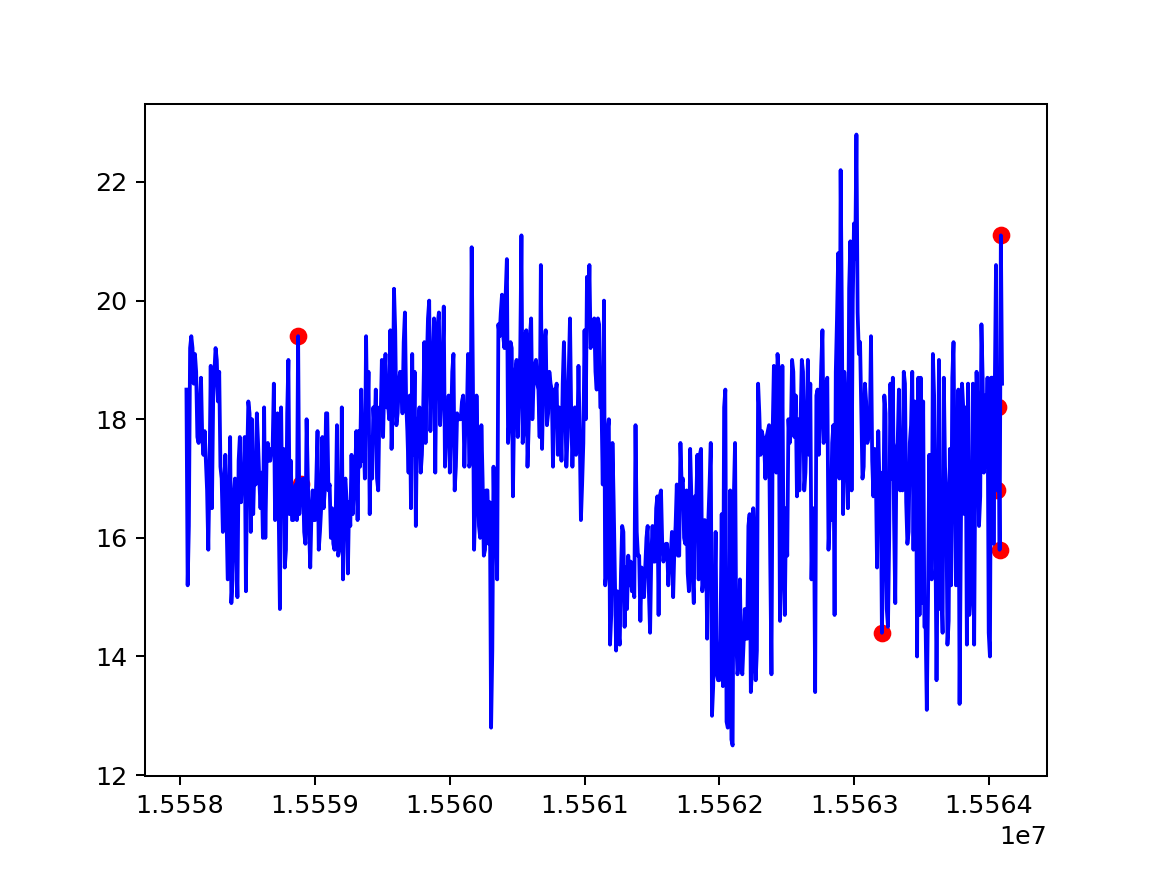

In [96]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly2'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

# One class SVM

Good for novelty detection (no anomalies in the train set). 


In [99]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly3'] = pd.Series(model.predict(data))
df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
print(df['anomaly3'].value_counts())

0    656
1     17
Name: anomaly3, dtype: int64


<IPython.core.display.Javascript object>


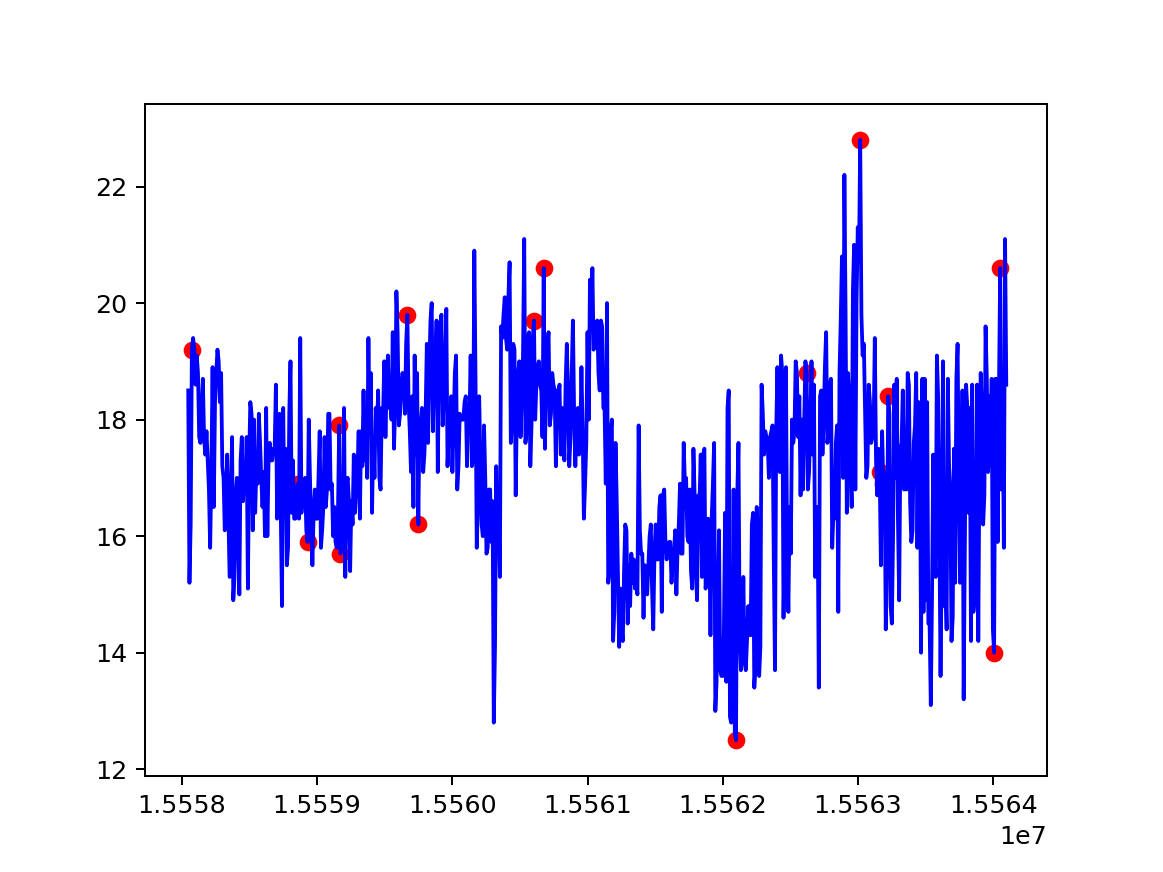

In [100]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly3'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


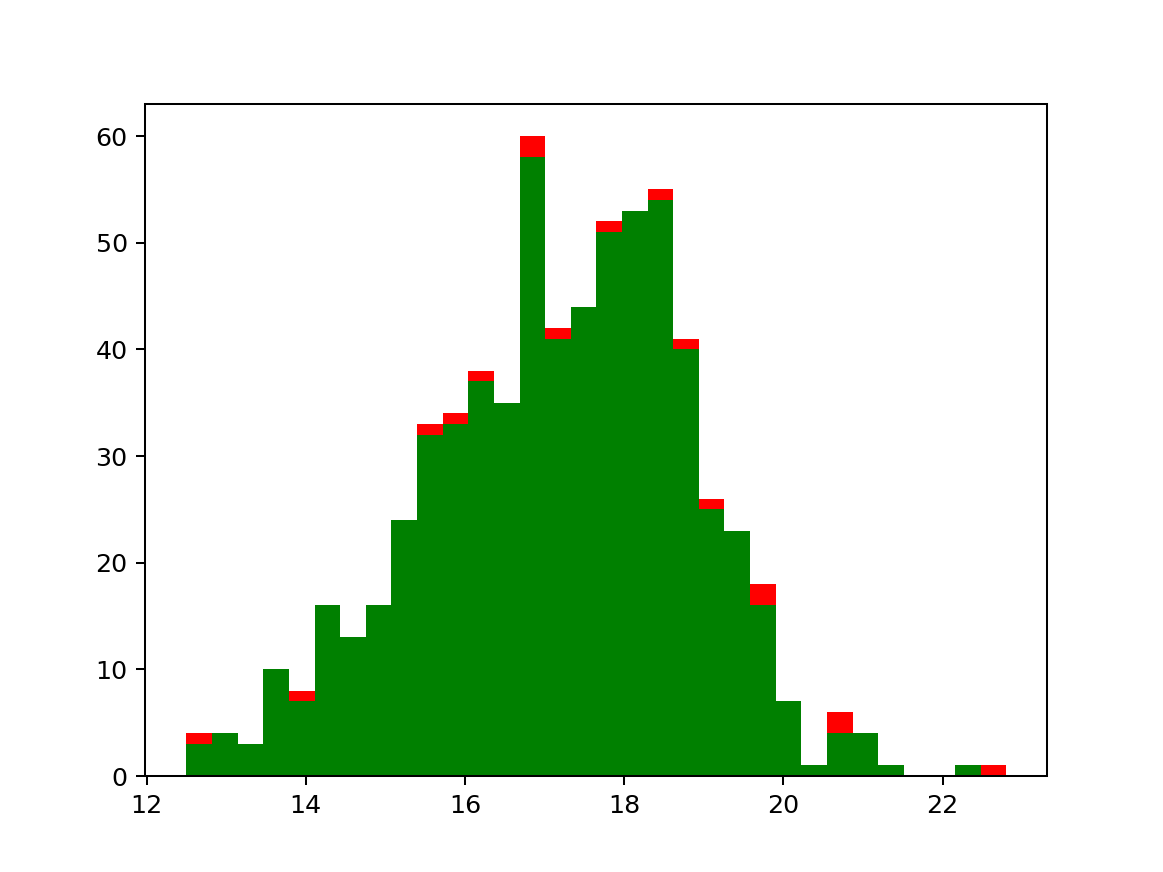

/Users/nkochura@us.ibm.com/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [101]:
# visualisation of anomaly with cou values repartition (viz 2)
a = df.loc[df['anomaly3'] == 0, 'value']
b = df.loc[df['anomaly3'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['green', 'red'])
plt.legend()
plt.show()